# Post-MVP Modeling

The purpose of this notebook is to improve the final model aka "Minimum Viable Product" that predicted with an F1 of 0.3955.

In [3]:
# importing relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')
import pickle

# NLP libraries
import nltk
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter
from sklearn import metrics, utils, model_selection, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report

In [4]:
# custom fuctions

import sys
sys.path.insert(0, '../src')
# module_path = sys.path.insert(0, '../src')

# if module_path not in sys.path:
#     sys.path.append(module_path)

import helper_functions as helpers

## Alternative Feature Engineering Method: Count Vectorization

### Importing X and y from `nlp_preprocesing.ipynb`

In [5]:
X_lem = pickle.load(open('../pickle/X_lem.pkl', 'rb'))
y_lem = pd.read_pickle('../pickle/y_lem.pkl')

In [6]:
# setting up stop words
stop_words = set(stopwords.words('english'))

### TTS & CountVectorize

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_lem, y_lem, test_size=0.20, random_state=20)

In [8]:
# using count vectorizor
count = CountVectorizer(stop_words=stop_words)

In [9]:
# fitting to the train and test set
X_train_count = count.fit_transform(X_train)
X_test_count = count.transform(X_test)

In [59]:
## pickling X_train for future use
pickle_out = open("../pickle/X_train_2.pkl","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

### Linear SVM Model (MVP)

In [10]:
SVM_baseline = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', class_weight='balanced')

In [11]:
%%time 
# 20 seconds to run

# fit the training dataset on the classifier
SVM_baseline.fit(X_train_count, y_train)
# predict the labels on validation dataset
SVM_test_preds = SVM_baseline.predict(X_test_count)

CPU times: user 22.1 s, sys: 311 ms, total: 22.4 s
Wall time: 22.6 s


In [12]:
SVM_precision = precision_score(y_test, SVM_test_preds)
SVM_recall = recall_score(y_test, SVM_test_preds)
SVM_f1_score = f1_score(y_test, SVM_test_preds)
SVM_f1_weighted = f1_score(y_test, SVM_test_preds, average='weighted')

# printing scores
helpers.evaluation(SVM_precision, SVM_recall, SVM_f1_score, SVM_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.2712
Recall: 0.5365
F1 Score: 0.3603
Weighted F1 Score: 0.9104


Unfortunately this model performed worse than the TFIDF version of this model, which had an F1 of .3955. Whereas this one has an F1 of .3603.

Maybe we can test out other baselines and see how they perform with CountVectorizor

### Random Forest

In [13]:
rf_baseline = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0)

In [14]:
%%time
# 14 seconds to run

rf_baseline.fit(X_train_count, y_train)
rf_test_preds = rf_baseline.predict(X_test_count)

CPU times: user 14.2 s, sys: 94.3 ms, total: 14.3 s
Wall time: 14.3 s


In [15]:
rf_precision = precision_score(y_test, rf_test_preds)
rf_recall = recall_score(y_test, rf_test_preds)
rf_f1_score = f1_score(y_test, rf_test_preds)
rf_f1_weighted = f1_score(y_test, rf_test_preds, average='weighted')

# printing scores
helpers.evaluation(rf_precision, rf_recall, rf_f1_score, rf_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.3173
Recall: 0.2883
F1 Score: 0.3021
Weighted F1 Score: 0.9247


This improved the original F1 of .232, but this F1 score is still pretty low compared to the TFIDF Linear SVM model.

### Logisitic Regression

In [16]:
logreg_baseline = LogisticRegression(penalty='l2', class_weight='balanced', random_state=20)

In [17]:
%%time
# 1 second to run

logreg_baseline.fit(X_train_count, y_train)
logreg_test_preds = logreg_baseline.predict(X_test_count)

CPU times: user 1.39 s, sys: 43.5 ms, total: 1.43 s
Wall time: 464 ms


In [18]:
logreg_precision = precision_score(y_test, logreg_test_preds)
logreg_recall = recall_score(y_test, logreg_test_preds)
logreg_f1_score = f1_score(y_test, logreg_test_preds)
logreg_f1_weighted = f1_score(y_test, logreg_test_preds, average='weighted')

# printing scores
helpers.evaluation(logreg_precision, logreg_recall, logreg_f1_score, logreg_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.2898
Recall: 0.6241
F1 Score: 0.3958
Weighted F1 Score: 0.9121


## Overfit or Underfit?

In [50]:
%%time
# training f1
baseline_f1_cv = cross_val_score(logreg_baseline, X_train_count, y_train, scoring='f1', cv=5)
baseline_mean_cv = round(baseline_f1_cv.mean(), 6)

CPU times: user 6.94 s, sys: 386 ms, total: 7.33 s
Wall time: 2.2 s


In [51]:
baseline_fit = helpers.model_fit(baseline_mean_cv, logreg_f1_score)
baseline_fit

'overfit'

In [53]:
# cross validated f1 score for training set
print('Training F1 Score: {:.5}'.format(baseline_mean_cv))
# uniform f1 score for testing set
print('Testing F1 Score: {:.5}'.format(logreg_f1_score))

Training F1 Score: 0.40072
Testing F1 Score: 0.39583


Good news, this model is only slightly overfit. Nothing to be to concerned about.

**Note:** for some reason, this model becomes underfit in `final_notebook.ipynb`. This could possibly be attributed to the train-test split's random state. However, although the training F1s are different, the testing F1s are exactly the same. So we can disregard this.

So this beat the TFIDF Log Reg score of .3878, and was slightly better than .3955 from the TFIDF Linear SVM. Let's try Naive Bayes next before trying out grid search on this model.

In [19]:
target_names = ['class 0', 'class 1']
print('-'*7 + ' Log Reg Baseline with Count Vectorizor ' + '-'*6)
print(classification_report(y_test, logreg_test_preds, target_names=target_names))

------- Log Reg Baseline with Count Vectorizor ------
              precision    recall  f1-score   support

     class 0       0.98      0.91      0.94      4683
     class 1       0.29      0.62      0.40       274

    accuracy                           0.89      4957
   macro avg       0.63      0.77      0.67      4957
weighted avg       0.94      0.89      0.91      4957



![img](../visualizations/mvp_class_report.png)

If we compare the classification report for both models, it's worth noting that this model predicts the "Not Hate Speech" label slightly worse than the original.

There's no change in the prediction of the "Hate Speech" label, but that's what needs to be changed. If there's no increase after grid search, then it wont be worth implimenting into the final_notebook.

### Naive Bayes

In [20]:
baseline_bayes = MultinomialNB(alpha = .01)

In [21]:
%%time
baseline_bayes.fit(X_train_count, y_train)
bayes_test_preds = baseline_bayes.predict(X_test_count)

CPU times: user 15.6 ms, sys: 2.57 ms, total: 18.2 ms
Wall time: 7.81 ms


In [22]:
bayes_precision = precision_score(y_test, bayes_test_preds)
bayes_recall = recall_score(y_test, bayes_test_preds)
bayes_f1_score = f1_score(y_test, bayes_test_preds)
bayes_f1_weighted = f1_score(y_test, bayes_test_preds, average='weighted')

# printing scores
helpers.evaluation(bayes_precision, bayes_recall, bayes_f1_score, bayes_f1_weighted)

Testing Set Evaluation Metrics:
Precision: 0.4459
Recall: 0.2409
F1 Score: 0.3128
Weighted F1 Score: 0.9332


There was a big increase from the original Bayes model that had an F1 of .1923. However, .3128 still isn't good enough.

## Improving Logistic Regression Model

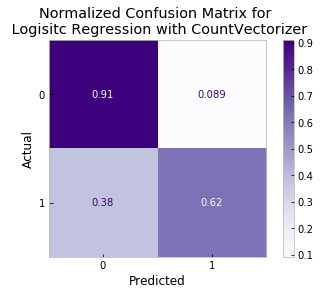

In [23]:
# generating normalized confusion matrix
SVM_conf_matrix = plot_confusion_matrix(logreg_baseline, X_test_count, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Purples,
                                 normalize='true')
SVM_conf_matrix.ax_.set_title('Normalized Confusion Matrix for \n Logisitc Regression with CountVectorizer')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
# plt.savefig('./visualizations/normalized_count_log_reg_matrix.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

Interestingly, this confusion matrix shows a much better score for the TPR! It bumped up from 0.44 to 0.62.

Before performing grid search, let's try Smote and Tomek Links to improve this model.

## Smote

In [24]:
sm = SMOTE(random_state=45)
smote_X_train, smote_y_train = sm.fit_sample(X_train_count, y_train)

In [25]:
smote_logreg = LogisticRegression(penalty='l2', random_state=55)

In [28]:
%%time
smote_logreg.fit(smote_X_train, smote_y_train)
smote_logreg_test_preds = smote_logreg.predict(X_test_count)

CPU times: user 1.84 s, sys: 32.7 ms, total: 1.87 s
Wall time: 518 ms


In [29]:
smote_precision = precision_score(y_test, smote_logreg_test_preds)
smote_recall = recall_score(y_test, smote_logreg_test_preds)
smote_f1_score = f1_score(y_test, smote_logreg_test_preds)
smote_weighted_f1_score = f1_score(y_test, smote_logreg_test_preds, average='weighted')

helpers.evaluation(smote_precision, smote_recall, smote_f1_score, smote_weighted_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.2348
Recall: 0.4781
F1 Score: 0.3149
Weighted F1 Score: 0.9028


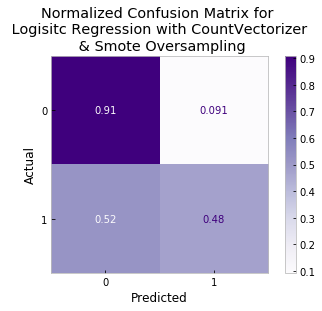

In [31]:
# generating normalized confusion matrix
SVM_conf_matrix = plot_confusion_matrix(smote_logreg, X_test_count, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Purples,
                                 normalize='true')
SVM_conf_matrix.ax_.set_title('Normalized Confusion Matrix for \n Logisitc Regression with CountVectorizer \n & Smote Oversampling')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
# plt.savefig('./visualizations/normalized_count_log_reg_matrix.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

This model performed worse than the inital logistic regression model, so next let's try tomek links to see if anything changes.

## Tomek Links

In [33]:
tl = TomekLinks()
tomek_X_train, tomek_y_train = tl.fit_resample(X_train_count, y_train)
print('Resampled dataset shape %s' % Counter(tomek_y_train))

Resampled dataset shape Counter({0: 18653, 1: 1156})


In [34]:
tomek_logreg = LogisticRegression(penalty='l2', random_state=55)

In [36]:
%%time
tomek_logreg.fit(tomek_X_train, tomek_y_train)
tomek_logreg_test_preds = tomek_logreg.predict(X_test_count)

CPU times: user 1.25 s, sys: 185 ms, total: 1.43 s
Wall time: 818 ms


In [37]:
tomek_precision = precision_score(y_test, tomek_logreg_test_preds)
tomek_recall = recall_score(y_test, tomek_logreg_test_preds)
tomek_f1_score = f1_score(y_test, tomek_logreg_test_preds)
tomek_weighted_f1_score = f1_score(y_test, tomek_logreg_test_preds, average='weighted')

helpers.evaluation(tomek_precision, tomek_recall, tomek_f1_score, tomek_weighted_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.5702
Recall: 0.2372
F1 Score: 0.3351
Weighted F1 Score: 0.9377


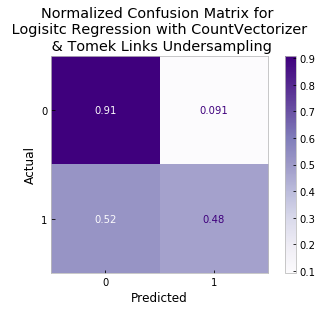

In [38]:
# generating normalized confusion matrix
SVM_conf_matrix = plot_confusion_matrix(smote_logreg, X_test_count, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Purples,
                                 normalize='true')
SVM_conf_matrix.ax_.set_title('Normalized Confusion Matrix for \n Logisitc Regression with CountVectorizer \n & Tomek Links Undersampling')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
# plt.savefig('./visualizations/normalized_count_log_reg_matrix.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

Overall, the Logisitic Regression basline is the best! Next let's try grid search to see if any improvement can be made.

It's worth noting that this Tomek Link Log Reg model has a better TPR than the MVP model. But it's still not better than the original Logisitic Regression model at the beginning of this notebook.

## Grid Search without resampling methods

In [39]:
# creating the model
baseline_log_reg = LogisticRegression(class_weight='balanced', random_state=50)

In [40]:
# creating param_dict
param_dict={'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'newton-cg', 'sag'], 'C':
[100, 10, 1.0, 0.1, 0.01]}

In [41]:
# instantiate Grid Search CV with F1 metric
grid_log_reg = GridSearchCV(baseline_log_reg, param_dict, cv=5, scoring='f1', verbose=1)

In [42]:
%%time
# fit the grid search to our data
grid_log_reg.fit(X_train_count, y_train)

# this cell takes 20 seconds to run

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   27.1s finished
CPU times: user 1min 3s, sys: 1.4 s, total: 1min 4s
Wall time: 27.5 s


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=50),
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'newton-cg', 'sag']},
             scoring='f1', verbose=1)

In [43]:
# generate score with .best_score_ and hyperparemeters with .best_params_
print('F1 Score:', grid_log_reg.best_score_)
print('Best Hyperparameters:', grid_log_reg.best_params_)
print('Model object with best parameters: ')
print(grid_log_reg.best_estimator_)

F1 Score: 0.4007240302332004
Best Hyperparameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Model object with best parameters: 
LogisticRegression(class_weight='balanced', random_state=50, solver='newton-cg')


In [58]:
# Predict the response for test dataset
grid_base_y_pred_train = grid_log_reg.best_estimator_.predict(X_train_count)

# predict the training set
grid_base_y_pred_test = grid_log_reg.best_estimator_.predict(X_test_count)

In [48]:
tuned_base_precision = precision_score(y_test, grid_base_y_pred_test)
tuned_base_recall = recall_score(y_test, grid_base_y_pred_test)
tuned_base_f1_score = f1_score(y_test, grid_base_y_pred_test)
tuned_weighted_f1_score = f1_score(y_test, tomek_logreg_test_preds, average='weighted')

helpers.evaluation(tuned_base_precision, tuned_base_recall, tuned_base_f1_score, tuned_weighted_f1_score)

Testing Set Evaluation Metrics:
Precision: 0.2898
Recall: 0.6241
F1 Score: 0.3958
Weighted F1 Score: 0.9377


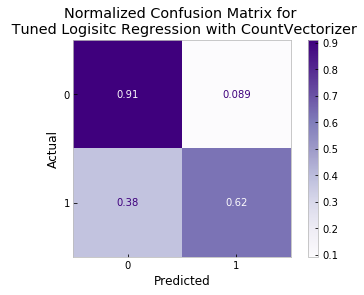

In [49]:
# generating normalized confusion matrix
SVM_conf_matrix = plot_confusion_matrix(grid_log_reg, X_test_count, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Purples,
                                 normalize='true')
SVM_conf_matrix.ax_.set_title('Normalized Confusion Matrix for \n Tuned Logisitc Regression with CountVectorizer')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.grid(False)
# plt.savefig('./visualizations/normalized_count_log_reg_matrix.png', bbox_inches = "tight", pad_inches=.5)
plt.show()

### Overfit or Underfit?

In [55]:
%%time
# training f1
tuned_f1_cv = cross_val_score(logreg_baseline, X_train_count, y_train, scoring='f1', cv=5)
tuned_mean_cv = round(tuned_f1_cv.mean(), 6)

CPU times: user 6.45 s, sys: 126 ms, total: 6.57 s
Wall time: 1.83 s


In [56]:
tuned_fit = helpers.model_fit(tuned_mean_cv, tuned_base_f1_score)
tuned_fit

'overfit'

In [57]:
# cross validated f1 score for training set
print('Training F1 Score: {:.5}'.format(tuned_mean_cv))
# uniform f1 score for testing set
print('Testing F1 Score: {:.5}'.format(tuned_base_f1_score))

Training F1 Score: 0.40072
Testing F1 Score: 0.39583


All of these evaluation metric methods reiterate that the tuned model is exactly the same as the baseline model. This outcome isn't surpising because there aren't many hyperparameters to tune with Logistic Regression.

Therefore, we can safely go with the basline Logistic Regression model with Count Vectorization as the new MVP. Although having a Recall (TPR) .62 isn't signifigantly better, at least it's better than just the random guessing is was before.